# Analyzing models so far
After a series of fixes to the pair engine, trying to get a new understanding of what's real.

In [1]:
from collections import OrderedDict
from importlib import reload

import numpy as np
import pandas as pd
from tqdm import tqdm
import graph_tool.all as gt
import matplotlib.pyplot as plt

from gptomics import graph, plot

In [2]:
def read_comps(filename, **kwargs):
    return pd.read_csv(filename, index_col=0, compression="gzip", **kwargs)

In [3]:
M125 = read_comps("../data/slurm/gpt-neo-125M_compositions.csv.gz")
B1p3 = read_comps("../data/slurm/gpt-neo-1.3B_compositions.csv.gz")
B2p7 = read_comps("../data/slurm/gpt-neo-2.7B_compositions.csv.gz")
J = read_comps("../data/slurm/gpt-j-6B_compositions.csv.gz")

M125_od = read_comps("../data/slurm/gpt-neo-125M_compositions_orig.csv.gz")
B1p3_od = read_comps("../data/slurm/gpt-neo-1.3B_compositions_orig.csv.gz")
B2p7_od = read_comps("../data/slurm/gpt-neo-2.7B_compositions_orig.csv.gz")
J_od = read_comps("../data/slurm/gpt-j-6B_compositions_orig.csv.gz")

In [4]:
def basic_value_plot(df, bounds=False, bins=50):
    plt.hist(df.term_value, bins=bins, color='k')
    plt.axvline(df.term_value.max(), ls='--', color='r')
    #plt.axvline(np.percentile(df.term_value.tolist(), 50), ls='--', color='b')
    #plt.axvline(np.percentile(df.term_value.tolist(), 99), ls='--', color='g')
    
    if bounds:
        plt.xlim(0, 1)
    
    plt.xlabel("Composition term value", fontsize=20)
    plt.ylabel("Count", fontsize=20)

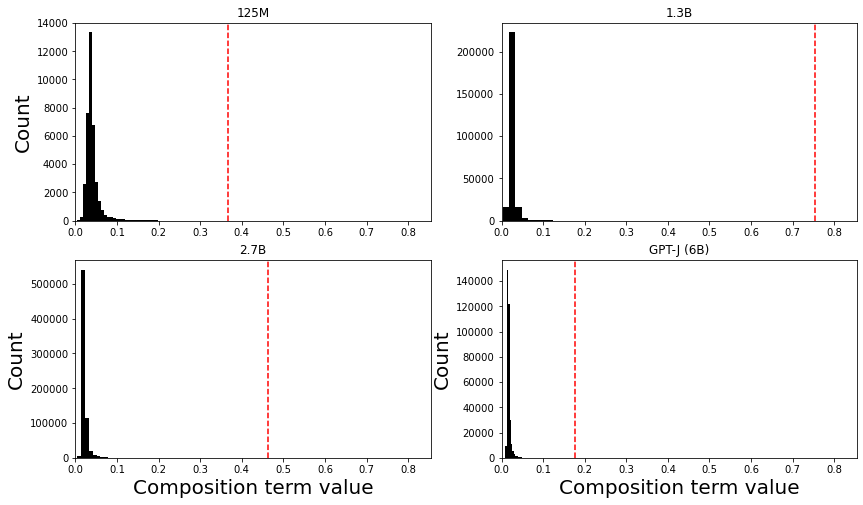

In [5]:
plt.figure(figsize=(14, 8), facecolor="white")

maxval = max(
    max(M125_od.term_value),
    max(B1p3_od.term_value),
    max(B2p7_od.term_value),
    max(J_od.term_value),
)

plt.subplot(2, 2, 1)
basic_value_plot(M125_od)
plt.title("125M")
plt.xlabel("")
plt.xlim(0, maxval+0.1)

plt.subplot(2, 2, 2)
basic_value_plot(B1p3_od)
plt.title("1.3B")
plt.xlim(0, maxval+0.1)
plt.ylabel("")
plt.xlabel("")

plt.subplot(2, 2, 3)
basic_value_plot(B2p7_od)
plt.title("2.7B")
plt.xlim(0, maxval+0.1)

plt.subplot(2, 2, 4)
basic_value_plot(J_od)
plt.title("GPT-J (6B)")
plt.xlim(0, maxval+0.1)

plt.show()

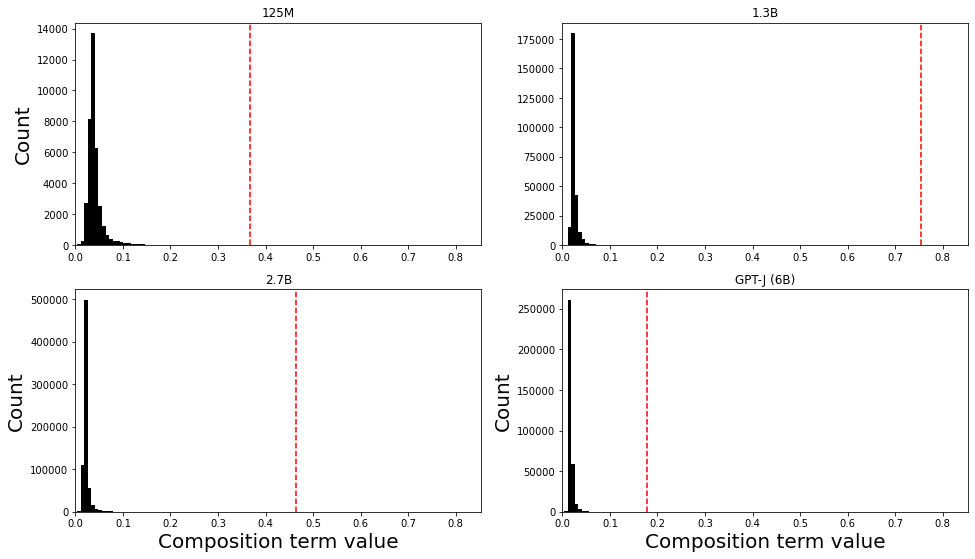

In [6]:
plt.figure(figsize=(16, 9), facecolor="white")

allvals = np.concatenate(
    (
        M125_od.term_value,
        B1p3_od.term_value,
        B2p7_od.term_value,
        J_od.term_value,
    )
)

maxval = max(allvals)
minval = min(allvals)
_, bins = np.histogram(allvals, bins=100)


plt.subplot(2, 2, 1)
basic_value_plot(M125_od, bins=bins)
plt.title("125M")
plt.xlabel("")
plt.xlim(0, maxval+0.1)

plt.subplot(2, 2, 2)
basic_value_plot(B1p3_od, bins=bins)
plt.title("1.3B")
plt.xlim(0, maxval+0.1)
plt.ylabel("")
plt.xlabel("")

plt.subplot(2, 2, 3)
basic_value_plot(B2p7_od, bins=bins)
plt.title("2.7B")
plt.xlim(0, maxval+0.1)

plt.subplot(2, 2, 4)
basic_value_plot(J_od, bins=bins)
plt.title("GPT-J (6B)")
plt.xlim(0, maxval+0.1)

plt.show()

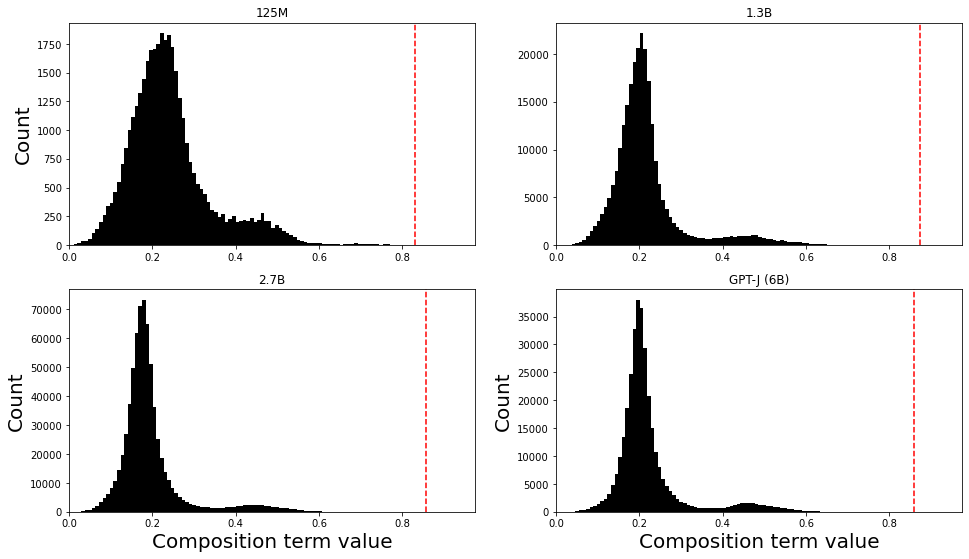

In [7]:
plt.figure(figsize=(16, 9), facecolor="white")

allvals = np.concatenate(
    (
        M125.term_value,
        B1p3.term_value,
        B2p7.term_value,
        J.term_value,
    )
)

maxval = max(allvals)
minval = min(allvals)
_, bins = np.histogram(allvals, bins=100)


plt.subplot(2, 2, 1)
basic_value_plot(M125, bins=bins)
plt.title("125M")
plt.xlabel("")
plt.xlim(0, maxval+0.1)

plt.subplot(2, 2, 2)
basic_value_plot(B1p3, bins=bins)
plt.title("1.3B")
plt.xlim(0, maxval+0.1)
plt.ylabel("")
plt.xlabel("")

plt.subplot(2, 2, 3)
basic_value_plot(B2p7, bins=bins)
plt.title("2.7B")
plt.xlim(0, maxval+0.1)

plt.subplot(2, 2, 4)
basic_value_plot(J, bins=bins)
plt.title("GPT-J (6B)")
plt.xlim(0, maxval+0.1)

plt.show()

In [8]:
colors = ["#171219", "#DA3E52", "#2E86AB", "#F18F01", "#531CB3"]

In [9]:
M125a = M125[(M125.src_type == "att_head") & (M125.dst_type == "att_head")]
B1p3a = B1p3[(B1p3.src_type == "att_head") & (B1p3.dst_type == "att_head")]
B2p7a = B2p7[(B2p7.src_type == "att_head") & (B2p7.dst_type == "att_head")]
Ja = J[(J.src_type == "att_head") & (J.dst_type == "att_head")]

M125_oda = M125_od[(M125_od.src_type == "att_head") & (M125_od.dst_type == "att_head")]
B1p3_oda = B1p3_od[(B1p3_od.src_type == "att_head") & (B1p3_od.dst_type == "att_head")]
B2p7_oda = B2p7_od[(B2p7_od.src_type == "att_head") & (B2p7_od.dst_type == "att_head")]
J_oda = J_od[(J_od.src_type == "att_head") & (J_od.dst_type == "att_head")]

In [10]:
def percentiles_by_type(
    df,
    type_colname="term_type",
    src_types=["att_head"],
    dst_types=["att_head"],
    types=["Q", "K", "V"],
    nbins=20,
):
    subdf = df[(df.src_type.isin(src_types))
               & (df.dst_type == "att_head")]
    
    return plot.percentiles_by_type(
        subdf, type_colname, types=types, colors=colors, nbins=nbins, legend=False,
    )

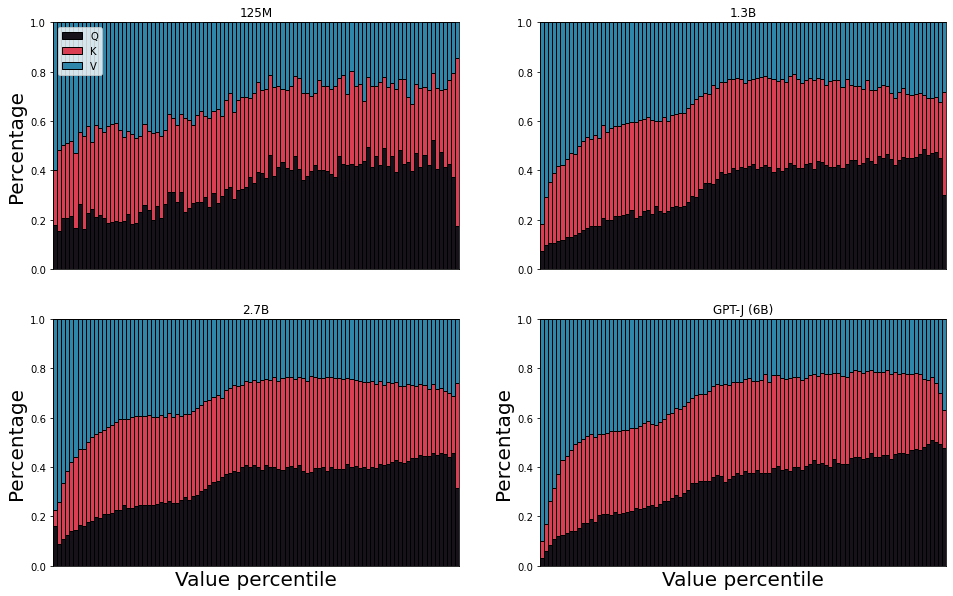

In [11]:
plt.figure(figsize=(16, 10), facecolor="white")

for (i, (name, df)) in enumerate(
    [("125M", M125_oda), ("1.3B", B1p3_oda), ("2.7B", B2p7_oda), ("GPT-J (6B)", J_oda)]
):
    plt.subplot(2, 2, i+1)
    percentiles_by_type(df, nbins=100)
    plt.title(name)
    if i == 0:
        plt.xlabel("")
        plt.legend(loc="upper left")
    elif i == 1:
        plt.ylabel("")
        plt.xlabel("")
    plt.xticks([])

    
plt.show()

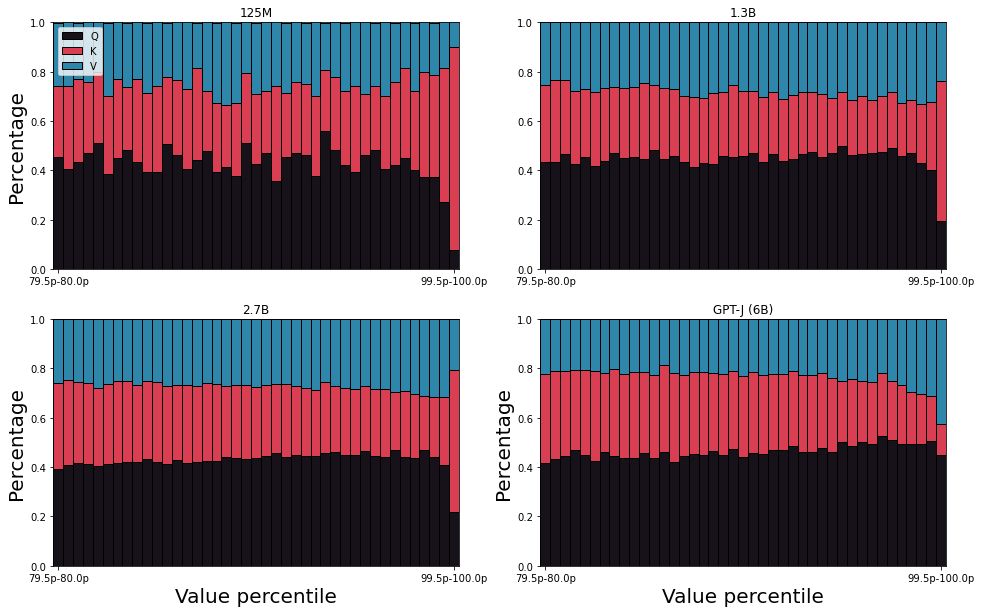

In [12]:
plt.figure(figsize=(16, 10), facecolor="white")

for (i, (name, df)) in enumerate(
    [("125M", M125_oda), ("1.3B", B1p3_oda), ("2.7B", B2p7_oda), ("GPT-J (6B)", J_oda)]
):
    plt.subplot(2, 2, i+1)
    percentiles_by_type(df, nbins=200)
    plt.title(name)
    if i == 0:
        plt.xlabel("")
        plt.legend(loc="upper left")
    elif i == 1:
        plt.ylabel("")
        plt.xlabel("")
    plt.xticks([160, 200], rotation=0)
    plt.xlim(159.5, 200.5)

    
plt.show()

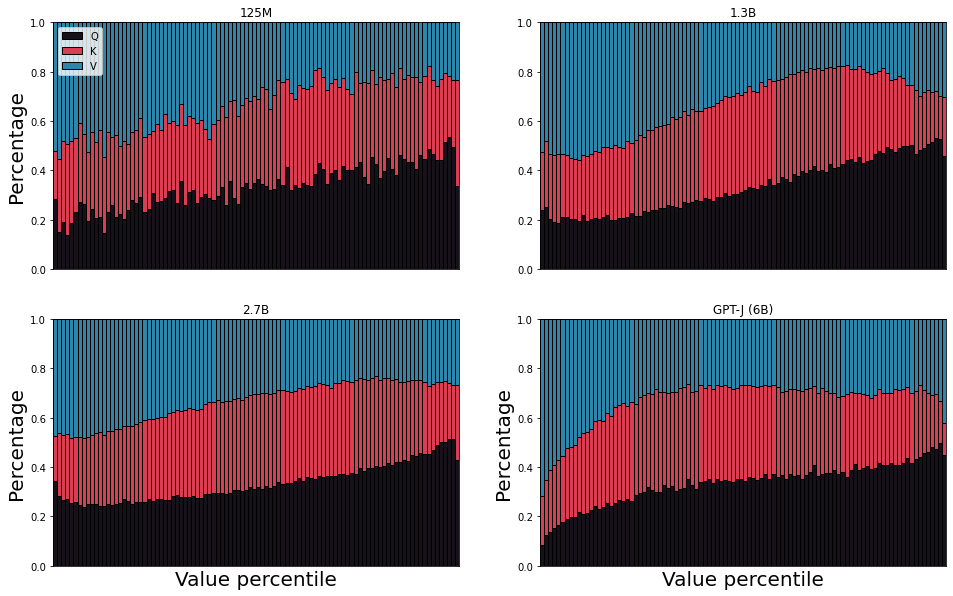

In [13]:
plt.figure(figsize=(16, 10), facecolor="white")

for (i, (name, df)) in enumerate(
    [("125M", M125), ("1.3B", B1p3), ("2.7B", B2p7), ("GPT-J (6B)", J)]
):
    plt.subplot(2, 2, i+1)
    percentiles_by_type(df, nbins=100)
    plt.title(name)
    if i == 0:
        plt.xlabel("")
        plt.legend(loc="upper left")
    elif i == 1:
        plt.ylabel("")
        plt.xlabel("")
    plt.xticks([])

    
plt.show()

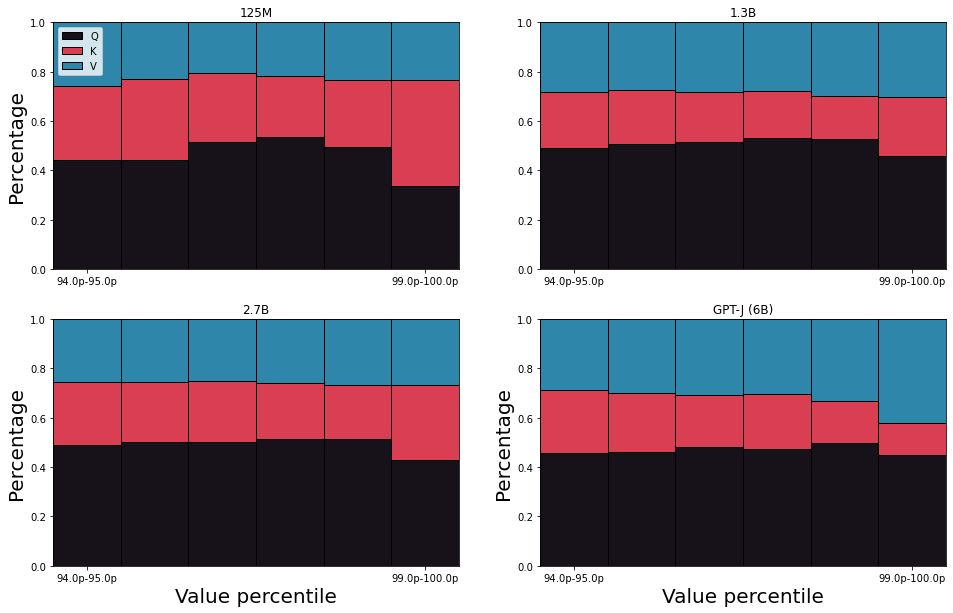

In [14]:
plt.figure(figsize=(16, 10), facecolor="white")

for (i, (name, df)) in enumerate(
    [("125M", M125), ("1.3B", B1p3), ("2.7B", B2p7), ("GPT-J (6B)", J)]
):
    plt.subplot(2, 2, i+1)
    percentiles_by_type(df, nbins=100)
    plt.title(name)
    if i == 0:
        plt.xlabel("")
        plt.legend(loc="upper left")
    elif i == 1:
        plt.ylabel("")
        plt.xlabel("")
    plt.xticks([95, 100], rotation=0)
    plt.xlim(94.5, 100.5)

    
plt.show()

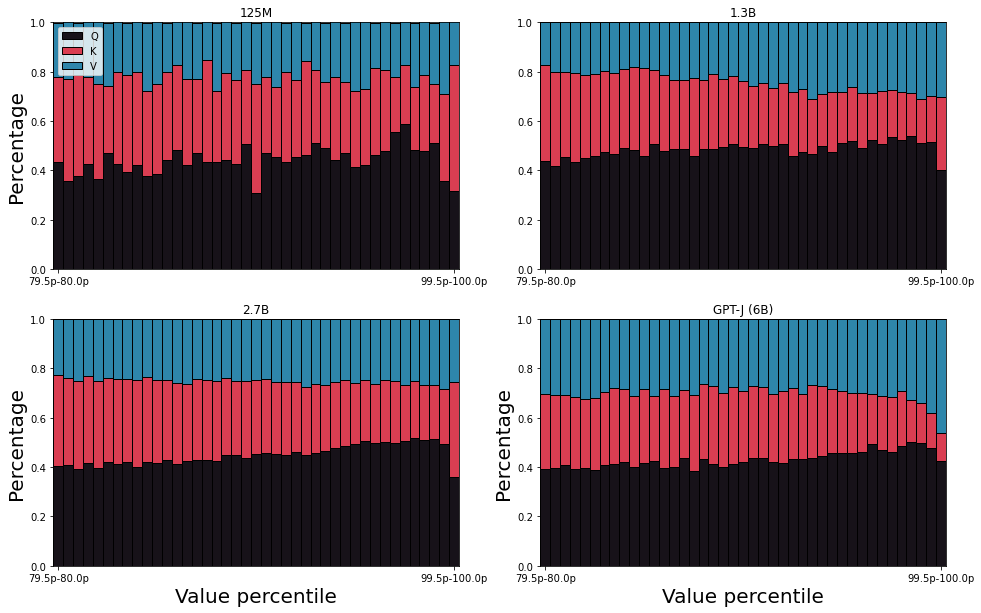

In [15]:
plt.figure(figsize=(16, 10), facecolor="white")

for (i, (name, df)) in enumerate(
    [("125M", M125), ("1.3B", B1p3), ("2.7B", B2p7), ("GPT-J (6B)", J)]
):
    plt.subplot(2, 2, i+1)
    percentiles_by_type(df, nbins=200)
    plt.title(name)
    if i == 0:
        plt.xlabel("")
        plt.legend(loc="upper left")
    elif i == 1:
        plt.ylabel("")
        plt.xlabel("")
    plt.xticks([160, 200], rotation=0)
    plt.xlim(159.5, 200.5)

    
plt.show()

In [16]:
def plot_count_by_head(df, percentile=99.5, term_type=None):
    num_blocks = max(df.dst_block) + 1
    num_heads = max(df.dst_index) + 1
    df = df[df.term_value >= np.percentile(df.term_value, percentile)]
    if term_type:
        df = df[df.term_type == term_type]
    num_received = np.zeros((num_blocks, num_heads), dtype=np.uint8)
    for i, j in zip(df.dst_block, df.dst_index):
        num_received[i, j] += 1

    plt.imshow(num_received.T, cmap="seismic")
    plt.xlabel("block", fontsize=20)
    plt.ylabel("attention head", fontsize=20)

In [17]:
def plot_sent_count_by_head(df, percentile=99.5, term_type=None):
    num_blocks = max(df.dst_block) + 1
    num_heads = max(df.dst_index) + 1
    df = df[df.term_value >= np.percentile(df.term_value, percentile)]
    if term_type:
        df = df[df.term_type == term_type]
    num_received = np.zeros((num_blocks, num_heads), dtype=np.uint8)
    for i, j in zip(df.src_block, df.src_index):
        num_received[i, j] += 1

    plt.imshow(num_received.T, cmap="seismic")
    plt.xlabel("block", fontsize=20)
    plt.ylabel("attention head", fontsize=20)

In [18]:
def plot_max_recvd_by_head(df, term_type=None):
    num_blocks = max(df.dst_block) + 1
    num_heads = max(df.dst_index) + 1
    if term_type:
        df = df[df.term_type == term_type]
        
    df = df.groupby(["src_block", "src_index"])["term_value"].max().reset_index()

    num_received = np.zeros((num_blocks, num_heads), dtype=np.float32)
    for i, j, t in zip(df.src_block, df.src_index, df.term_value):
        num_received[i, j] += t

    plt.imshow(num_received.T, cmap="seismic")
    plt.xlabel("block", fontsize=20)
    plt.ylabel("attention head", fontsize=20)

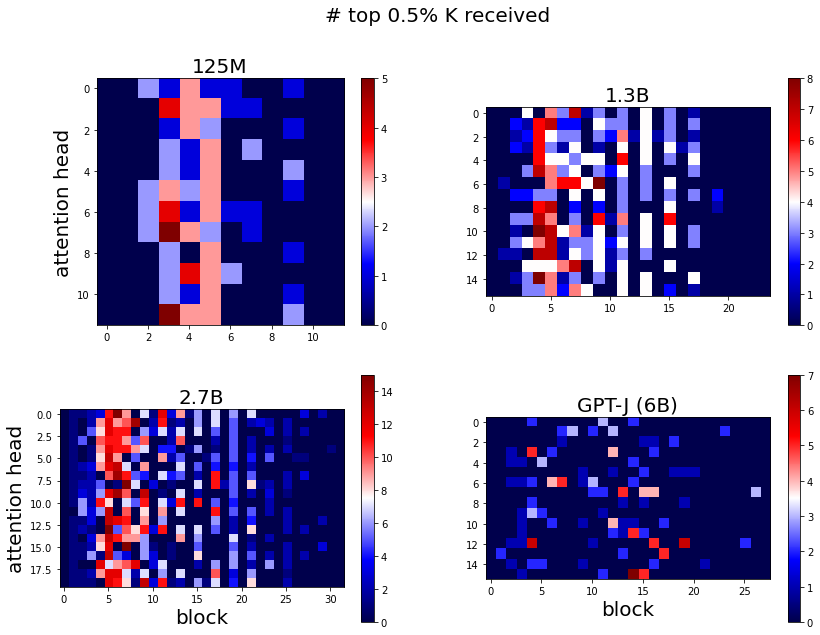

In [19]:
plt.figure(figsize=(14, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(M125_oda, term_type="K")
plt.colorbar()
plt.title("125M", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(B1p3_oda, term_type="K")
plt.colorbar()
plt.title("1.3B", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(B2p7_oda, term_type="K")
plt.colorbar()
plt.title("2.7B", fontsize=20)

plt.subplot(2, 2, 4)
plot_count_by_head(J_oda, term_type="K")
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("GPT-J (6B)", fontsize=20)
plt.ylabel("")

plt.suptitle("# top 0.5% K received", fontsize=20)

plt.show()

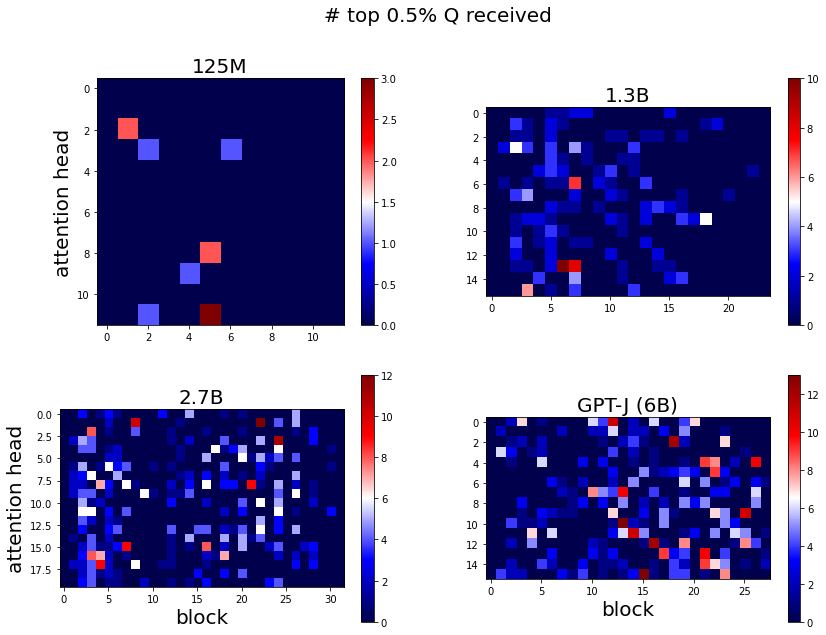

In [20]:
plt.figure(figsize=(14, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(M125_oda, term_type="Q")
plt.colorbar()
plt.title("125M", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(B1p3_oda, term_type="Q")
plt.colorbar()
plt.title("1.3B", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(B2p7_oda, term_type="Q")
plt.colorbar()
plt.title("2.7B", fontsize=20)

plt.subplot(2, 2, 4)
plot_count_by_head(J_oda, term_type="Q")
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("GPT-J (6B)", fontsize=20)
plt.ylabel("")

plt.suptitle("# top 0.5% Q received", fontsize=20)

plt.show()

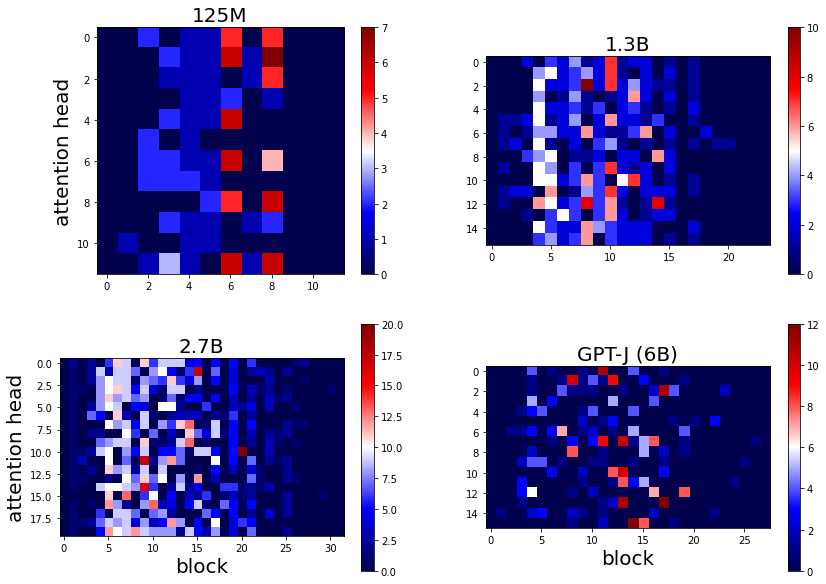

In [21]:
plt.figure(figsize=(14, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(M125a, percentile=99, term_type="K")
plt.colorbar()
plt.title("125M", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(B1p3a, percentile=99, term_type="K")
plt.colorbar()
plt.title("1.3B", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(B2p7a, percentile=99, term_type="K")
plt.colorbar()
plt.title("2.7B", fontsize=20)

plt.subplot(2, 2, 4)
plot_count_by_head(Ja, percentile=99, term_type="K")
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("GPT-J (6B)", fontsize=20)
plt.ylabel("")

plt.show()

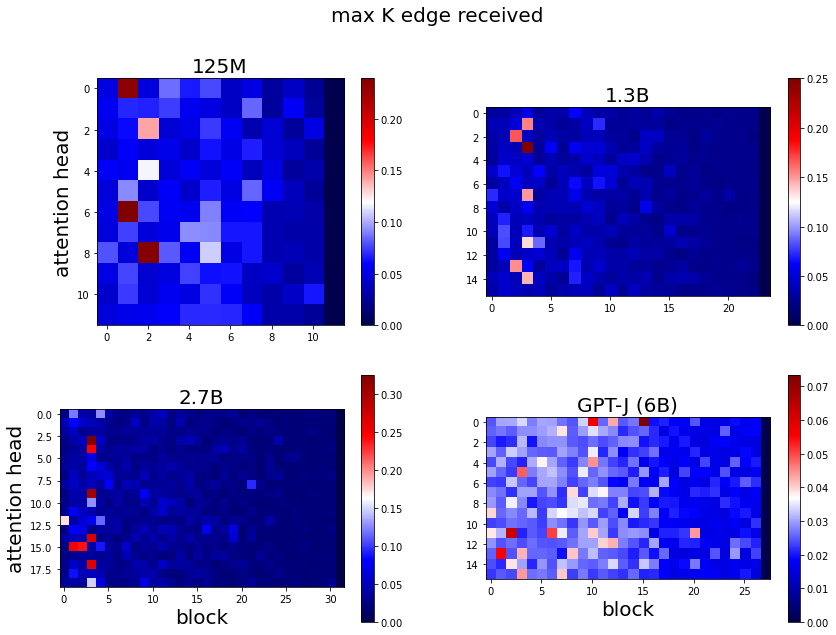

In [22]:
plt.figure(figsize=(14, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_max_recvd_by_head(M125_oda, term_type="K")
plt.colorbar()
plt.title("125M", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_max_recvd_by_head(B1p3_oda, term_type="K")
plt.colorbar()
plt.title("1.3B", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_max_recvd_by_head(B2p7_oda, term_type="K")
plt.colorbar()
plt.title("2.7B", fontsize=20)

plt.subplot(2, 2, 4)
plot_max_recvd_by_head(J_oda, term_type="K")
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("GPT-J (6B)", fontsize=20)
plt.ylabel("")

plt.suptitle("max K edge received", fontsize=20)

plt.show()

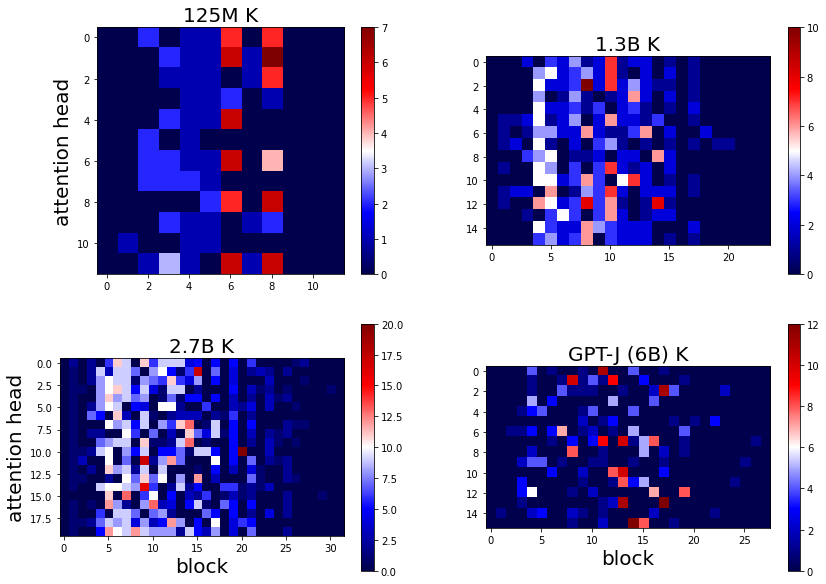

In [23]:
plt.figure(figsize=(14, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(M125a, percentile=99, term_type="K")
plt.colorbar()
plt.title("125M K", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(B1p3a, percentile=99, term_type="K")
plt.colorbar()
plt.title("1.3B K", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(B2p7a, percentile=99, term_type="K")
plt.colorbar()
plt.title("2.7B K", fontsize=20)

plt.subplot(2, 2, 4)
plot_count_by_head(Ja, percentile=99, term_type="K")
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("GPT-J (6B) K", fontsize=20)
plt.ylabel("")

#plt.suptitle("top 1%", fontsize=20)

plt.show()

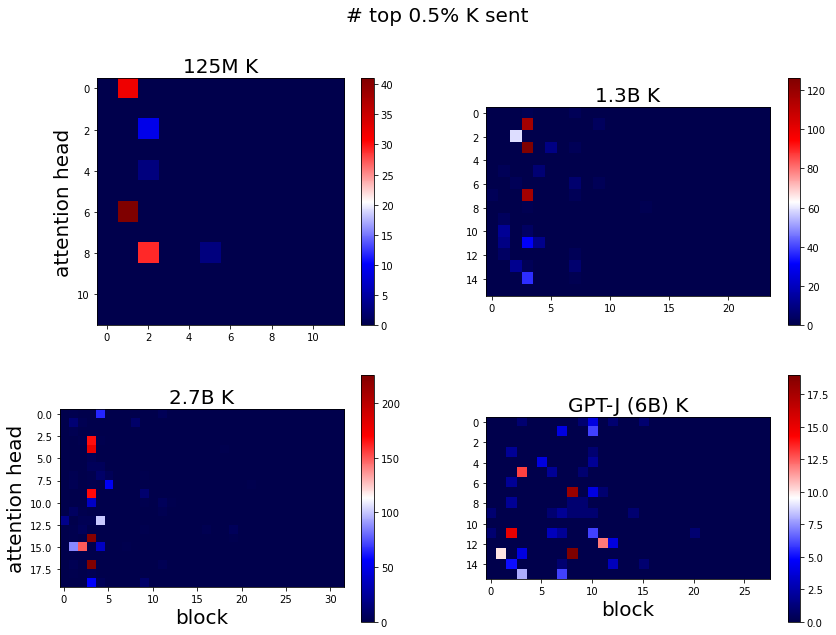

In [24]:
plt.figure(figsize=(14, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_sent_count_by_head(M125_oda, term_type="K")
plt.colorbar()
plt.title("125M K", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_sent_count_by_head(B1p3_oda, term_type="K")
plt.colorbar()
plt.title("1.3B K", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_sent_count_by_head(B2p7_oda, term_type="K")
plt.colorbar()
plt.title("2.7B K", fontsize=20)

plt.subplot(2, 2, 4)
plot_sent_count_by_head(J_oda, term_type="K")
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("GPT-J (6B) K", fontsize=20)
plt.ylabel("")

plt.suptitle("# top 0.5% K sent", fontsize=20)

plt.show()

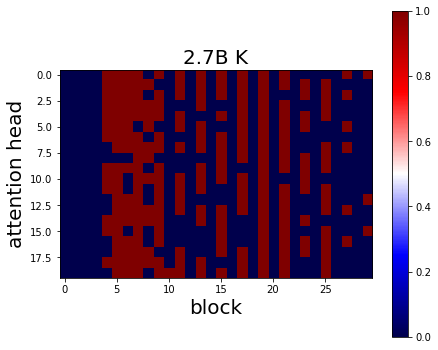

In [25]:
plt.figure(figsize=(7, 6), facecolor="white")

plot_count_by_head(
    B2p7_oda[
    (B2p7_oda.src_block == 3)
    & (B2p7_oda.src_index == 17)
    & (B2p7_oda.term_value >= np.percentile(B2p7_oda.term_value, 99.5))
    & (B2p7_oda.term_type == "K")
], percentile=0, term_type="K")
plt.colorbar()
plt.title("2.7B K", fontsize=20)

plt.show()

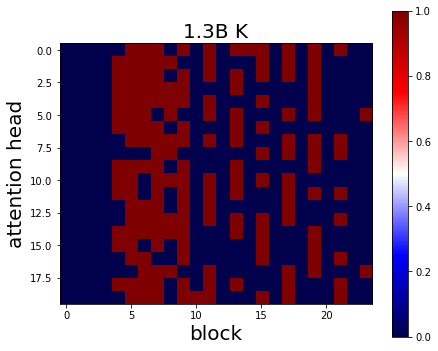

In [26]:
plt.figure(figsize=(7, 6), facecolor="white")

plot_count_by_head(
    B2p7_oda[
    (B2p7_oda.src_block == 3)
    & (B2p7_oda.src_index == 3)
    & (B2p7_oda.term_value >= np.percentile(B2p7_oda.term_value, 99.5))
    & (B2p7_oda.term_type == "K")
], percentile=0, term_type="K")
plt.colorbar()
plt.title("1.3B K", fontsize=20)

plt.show()

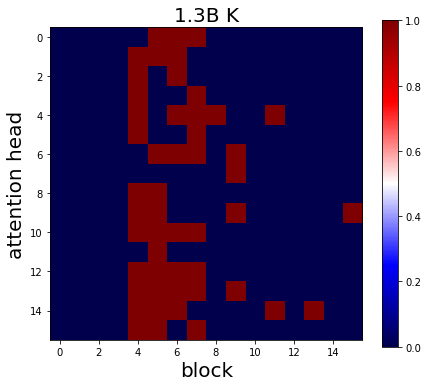

In [27]:
plt.figure(figsize=(7, 6), facecolor="white")

plot_count_by_head(
    B1p3_oda[
    (B1p3_oda.src_block == 3)
    & (B1p3_oda.src_index == 14)
    & (B1p3_oda.term_value >= np.percentile(B2p7_oda.term_value, 99.5))
    & (B1p3_oda.term_type == "K")
], percentile=0, term_type="K")
plt.colorbar()
plt.title("1.3B K", fontsize=20)

plt.show()

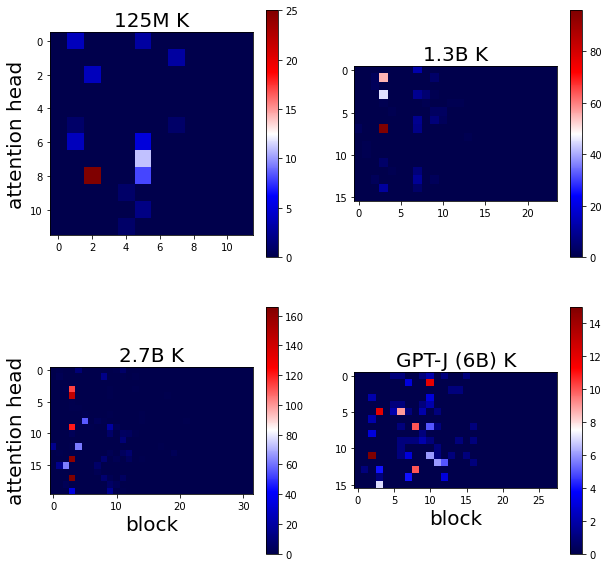

In [28]:
plt.figure(figsize=(10, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_sent_count_by_head(M125a, term_type="K")
plt.colorbar()
plt.title("125M K", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_sent_count_by_head(B1p3a, term_type="K")
plt.colorbar()
plt.title("1.3B K", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_sent_count_by_head(B2p7a, term_type="K")
plt.colorbar()
plt.title("2.7B K", fontsize=20)

plt.subplot(2, 2, 4)
plot_sent_count_by_head(Ja, term_type="K")
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("GPT-J (6B) K", fontsize=20)
plt.ylabel("")

#plt.suptitle("top 1%", fontsize=20)

plt.show()

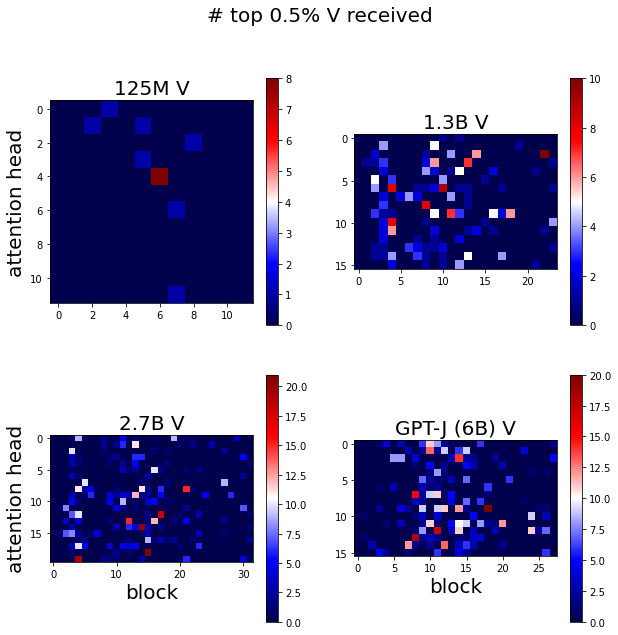

In [29]:
plt.figure(figsize=(10, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(M125_oda, term_type="V")
plt.colorbar()
plt.title("125M V", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(B1p3_oda, term_type="V")
plt.colorbar()
plt.title("1.3B V", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(B2p7_oda, term_type="V")
plt.colorbar()
plt.title("2.7B V", fontsize=20)

plt.subplot(2, 2, 4)
plot_count_by_head(J_oda, term_type="V")
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("GPT-J (6B) V", fontsize=20)
plt.ylabel("")

plt.suptitle("# top 0.5% V received", fontsize=20)

plt.show()

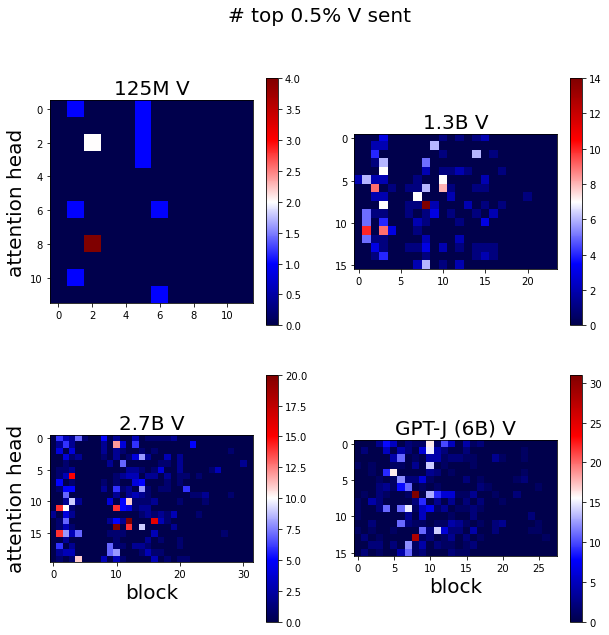

In [30]:
plt.figure(figsize=(10, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_sent_count_by_head(M125_oda, term_type="V")
plt.colorbar()
plt.title("125M V", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_sent_count_by_head(B1p3_oda, term_type="V")
plt.colorbar()
plt.title("1.3B V", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_sent_count_by_head(B2p7_oda, term_type="V")
plt.colorbar()
plt.title("2.7B V", fontsize=20)

plt.subplot(2, 2, 4)
plot_sent_count_by_head(J_oda, term_type="V")
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("GPT-J (6B) V", fontsize=20)
plt.ylabel("")

plt.suptitle("# top 0.5% V sent", fontsize=20)

plt.show()